## Assignment 2: Adversarial Training

This assignment requires you to create adversarial examples. You will do adversarial training, i.e., train the model with sets of adversarial examples you generated and evaluate the performances of the model on test sets.

### What is Adversarial Training?
Adversarial training is a machine learning technique to improve models' robustness by training them on adversarial examples. Adversarial examples are input data that has been intentionally modified to cause the model to misclassify or produce an incorrect output.

When a model is trained using adversarial examples, it becomes more resilient to adversarial attacks and is able to better identify and classify input data that may have been modified or corrupted. This may lead to improved performance of the model in real-world scenarios where the input data may not always be perfect.

However, adversarial training can also have some negative impacts on ML models. For example, it can lead to overfitting, where the model becomes too specialized to the particular adversarial examples used in training and is unable to generalize well to new examples. Additionally, adversarial training can increase the computational requirements of training the model due to the need for generating adversarial examples.

Overall, while adversarial training can improve the robustness of ML models, it is important to carefully consider its potential benefits and drawbacks and to evaluate the trade-offs in terms of model performance and computational requirements. The following are the steps involved in adversarial training:

1. Generate adversarial examples: In the first step, we generate adversarial examples by perturbing the original data points in such a way that the modifications are small and not noticeable to humans but are enough to cause misclassification by the neural network.

2. Train on adversarial examples: In the second step, we train the neural network on adversarial examples in addition to the original training data. This helps to improve the network's ability to recognize and classify adversarial examples correctly.

3. Evaluate performance: In the third step, we evaluate the performance of the network on both the original and adversarial test data. This helps to determine if the adversarial training has improved the network's robustness against adversarial attacks.

Overall, adversarial training is a powerful technique that can help improve the security and reliability of deep neural networks.

### Problem Statement
In this Homework, you will run different adversarial training algorithms on the ResNet18 model with the adversarial examples using the CIFAR-10 dataset, and evaluating the model performances on test data. The goal is to get experience in generating adversarial examples and train the model with these examples, i.e., adversarial training.

We have provided the model architecture (`model.py`) and some pre-defined functions (`utils.py`) so you can import and use them directly in the notebook.

In [1]:
import torch
import torch.nn as nn # type: ignore
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from model import ResNet18
from utils import trades_loss, mixup_data, mixup_criterion, make_dataloader, eval_test

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Q1 (20 points)
Use the following parameters to define the LinfPGDAttack():

- Epsilon: 8/255
- PGD Steps: 10
- PGD Step Size: 0.003

In [2]:
class LinfPGDAttack(nn.Module):
    def __init__(self, model, epsilon=8/255, steps=10, step_size=0.003):
        super().__init__()
        self.model = model
        self.epsilon = epsilon
        self.steps = steps
        self.step_size = step_size

    def perturb(self, x_natural, y):
        """
        Computes the gradient of the cross-entropy loss with respect to the input
        image `x_adv` and updates the image based on the gradient direction. The
        perturbation is clipped to ensure it stays within a specified epsilon range
        and is finally clamped to ensure pixel values are valid.

        The resulting perturbed image is returned.
        """
        # *********** Your code starts here ***********
        with torch.enable_grad():
          x_adv = x_natural.clone().detach() # not to mess up gradients
          for _ in range(self.steps):
            x_adv.requires_grad_()
            outputs = self.model(x_adv).requires_grad_(True)
            loss = F.cross_entropy(outputs, y) #calculate loss
            grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0] #calc gradients
            x_adv = x_adv + self.step_size * grad.sign()
            delta = torch.clamp(x_adv - x_natural, -self.epsilon, self.epsilon) #limit step size
            x_adv = torch.clamp(x_natural + delta, 0, 1).detach() #prevent from going out of range
          return x_adv

        # *********** Your code ends here *************

        return x_adv

    def forward(self, x_natural, y):
        x_adv = self.perturb(x_natural, y)
        return x_adv

There are many implementations of adversarial training; in this assignment, we ask you to evalaute which training algorithm can make the model more robust to LinfPGDAttack().

In [3]:
def train_ep(model, train_loader, mode, pgd_attack, optimizer, criterion, epoch, batch_size):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        if mode == 'natural':
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        elif mode == 'adv_train': # [Ref] https://arxiv.org/abs/1706.06083
            model.eval()
            adv_x = pgd_attack(inputs, targets)
            model.train()

            optimizer.zero_grad()
            outputs = model(adv_x)
            loss = criterion(outputs, targets)

        elif mode == 'adv_train_trades': # [Ref] https://arxiv.org/abs/1901.08573
            optimizer.zero_grad()
            loss = trades_loss(model=model, x_natural=inputs, y=targets, optimizer=optimizer)

        elif mode == 'adv_train_mixup': # [Ref] https://arxiv.org/abs/1710.09412
            model.eval()
            benign_inputs, benign_targets_a, benign_targets_b, benign_lam = mixup_data(inputs, targets)
            adv_x = pgd_attack(inputs, targets)
            adv_inputs, adv_targets_a, adv_targets_b, adv_lam = mixup_data(adv_x, targets)

            model.train()
            optimizer.zero_grad()

            benign_outputs = model(benign_inputs)
            adv_outputs = model(adv_inputs)
            loss_1 = mixup_criterion(criterion, benign_outputs, benign_targets_a, benign_targets_b, benign_lam)
            loss_2 = mixup_criterion(criterion, adv_outputs, adv_targets_a, adv_targets_b, adv_lam)

            loss = (loss_1 + loss_2) / 2

        else:
            print("No training mode specified.")
            raise ValueError()

        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(inputs), len(train_loader) * batch_size,
                       100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [4]:
def train(model, train_loader, val_loader, pgd_attack,
          mode='natural', epochs=25, batch_size=256, learning_rate=0.1, momentum=0.9, weight_decay=2e-4,
          checkpoint_path='model1.pt'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    best_acc = 0
    for epoch in range(epochs):
        # training
        train_ep(model, train_loader, mode, pgd_attack, optimizer, criterion, epoch, batch_size)

        # evaluate clean accuracy
        test_loss, test_acc = eval_test(model, val_loader, device)

        # remember best acc@1 and save checkpoint
        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)

        # save checkpoint if is a new best
        if is_best:
            torch.save(model.state_dict(), checkpoint_path)
        print('================================================================')

### Q2 (40 points)
Use the four training modes ("natural", "adv_train", "adv_train_trades", and "adv_train_mixup") to obtain four models, and save them as $\texttt{model1.pt}$, $\texttt{model2.pt}$, $\texttt{model3.pt}$, and $\texttt{model4.pt}$, respectively.

When calculating your losses, you may encounter Nan. In this case, you may consider adjusting the `learning rate` to solve the problem.

In [5]:
# define parameters
batch_size = 256
data_path = "../data" # directory of the data
epsilon = 8/255
steps = 10
epochs = 25

# create data loader
train_loader, val_loader = make_dataloader(data_path, batch_size)

100%|██████████| 170M/170M [00:14<00:00, 11.7MB/s]


In [9]:
training_mode = "natural"

# Define Model and Launch Training (Define Adversary If You Need It)

# Write your code here
# create model
model = ResNet18()
model = model.to(device)

# train model
train(model, train_loader, val_loader, pgd_attack=None, mode='natural', epochs=25, batch_size=batch_size, learning_rate=.001, checkpoint_path='model1.pt')


Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.525774
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 1.905734
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 1.723237
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 1.555760
Test: Average loss: 0.0064, Accuracy: 4272/10000 (43%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 1.510909
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 1.431671
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 1.426199
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.319594
Test: Average loss: 0.0051, Accuracy: 5385/10000 (54%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.266731
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.203878
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.187827
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 1.117853
Test: Average loss: 0.0047, Accuracy: 5819/10000 (58%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.037710
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.179182
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 1.084787
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.031248
Test: Average loss: 0.0

In [8]:
training_mode = "adv_train"

# Define Model and Launch Training (Define Adversary If You Need It)

# Write your code here
model = ResNet18()
model = model.to(device)
pgd_attack = LinfPGDAttack(model, epsilon, steps)
train(model, train_loader, val_loader, pgd_attack=pgd_attack, mode='adv_train', epochs=25, batch_size=batch_size, learning_rate=.001, checkpoint_path='model2.pt')

Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.439231
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 2.514900
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 2.244867
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 2.242260
Test: Average loss: 0.0076, Accuracy: 3019/10000 (30%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 2.156119
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 2.178153
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 2.194627
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 2.047406
Test: Average loss: 0.0072, Accuracy: 3586/10000 (36%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 2.051933
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.959569
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.984598
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 2.021133
Test: Average loss: 0.0070, Accuracy: 3704/10000 (37%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 2.086110
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 2.133447
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 2.001236
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.983514
Test: Average loss: 0.0

In [16]:
training_mode = "adv_train_trades"

# Define Model and Launch Training (Define Adversary If You Need It)

# Write your code here
model = ResNet18()
model = model.to(device)
pgd_attack = LinfPGDAttack(model, epsilon, steps)
train(model, train_loader, val_loader, pgd_attack=pgd_attack, mode='adv_train_trades', epochs=25, batch_size=batch_size, learning_rate=.001, checkpoint_path='model3.pt')


/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.382128
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 2.126883
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 1.914271
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 1.911676
Test: Average loss: 0.0067, Accuracy: 3854/10000 (39%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 1.805378
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 1.807636
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 1.691453
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.715614
Test: Average loss: 0.0063, Accuracy: 4296/10000 (43%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.679115
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.614146
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.603180
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 1.624028
Test: Average loss: 0.0059, Accuracy: 4637/10000 (46%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.563215
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.601577
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 1.472342
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.627716
Test: Average loss: 0.0

In [6]:
training_mode = "adv_train_mixup"

# Define Model and Launch Training (Define Adversary If You Need It)

# Write your code here
model = ResNet18()
model = model.to(device)
pgd_attack = LinfPGDAttack(model, epsilon, steps)
train(model, train_loader, val_loader, pgd_attack=pgd_attack, mode='adv_train_mixup', epochs=25, batch_size=batch_size, learning_rate=.001, checkpoint_path='model4.pt')

Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.449242
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 2.283528
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 2.028460
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 2.105959
Test: Average loss: 0.0069, Accuracy: 3870/10000 (39%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 2.096086
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 2.085776
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 2.086530
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.909372
Test: Average loss: 0.0065, Accuracy: 4179/10000 (42%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.896959
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.990040
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 2.038569
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 2.053320
Test: Average loss: 0.0064, Accuracy: 4294/10000 (43%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.899727
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.980169
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 1.841902
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 2.008202
Test: Average loss: 0.0

### Q3 (20 points)
Use eval_robust() to evaluate each model's robustness against LinfPGDAttack().

In [34]:
from utils import eval_robust

model = ResNet18()
model = model.to(device)
model.load_state_dict(torch.load('model1.pt'))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
model.train()
for param in model.parameters():
    param.requires_grad = True
robust_loss, robust_acc = eval_robust(model, val_loader, pgd_attack, device)

LinfPGD Attack: Average loss: 0.0786, Robust Accuracy: 9/10000 (0%)


In [15]:
from utils import eval_robust

model = ResNet18()
model = model.to(device)
model.load_state_dict(torch.load('model2.pt'))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
model.train()
for param in model.parameters():
    param.requires_grad = True
robust_loss, robust_acc = eval_robust(model, val_loader, pgd_attack, device)

LinfPGD Attack: Average loss: 0.0072, Robust Accuracy: 3155/10000 (32%)


In [17]:
# *********** Your code starts here ***********
from utils import eval_robust
model = ResNet18()
model = model.to(device)
model.load_state_dict(torch.load('model3.pt'))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
robust_loss, robust_acc = eval_robust(model, val_loader, pgd_attack, device)


# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0079, Robust Accuracy: 2670/10000 (27%)


In [8]:
# *********** Your code starts here ***********
from utils import eval_robust
model = ResNet18()
model = model.to(device)
model.load_state_dict(torch.load('model4.pt'))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
robust_loss, robust_acc = eval_robust(model, val_loader, pgd_attack, device)


# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0079, Robust Accuracy: 2578/10000 (26%)


### Q4 (10 points)
Visualize 10 adversarial examples from (with ground truth labels and model's predictions) from the model having best robust accuarcy.

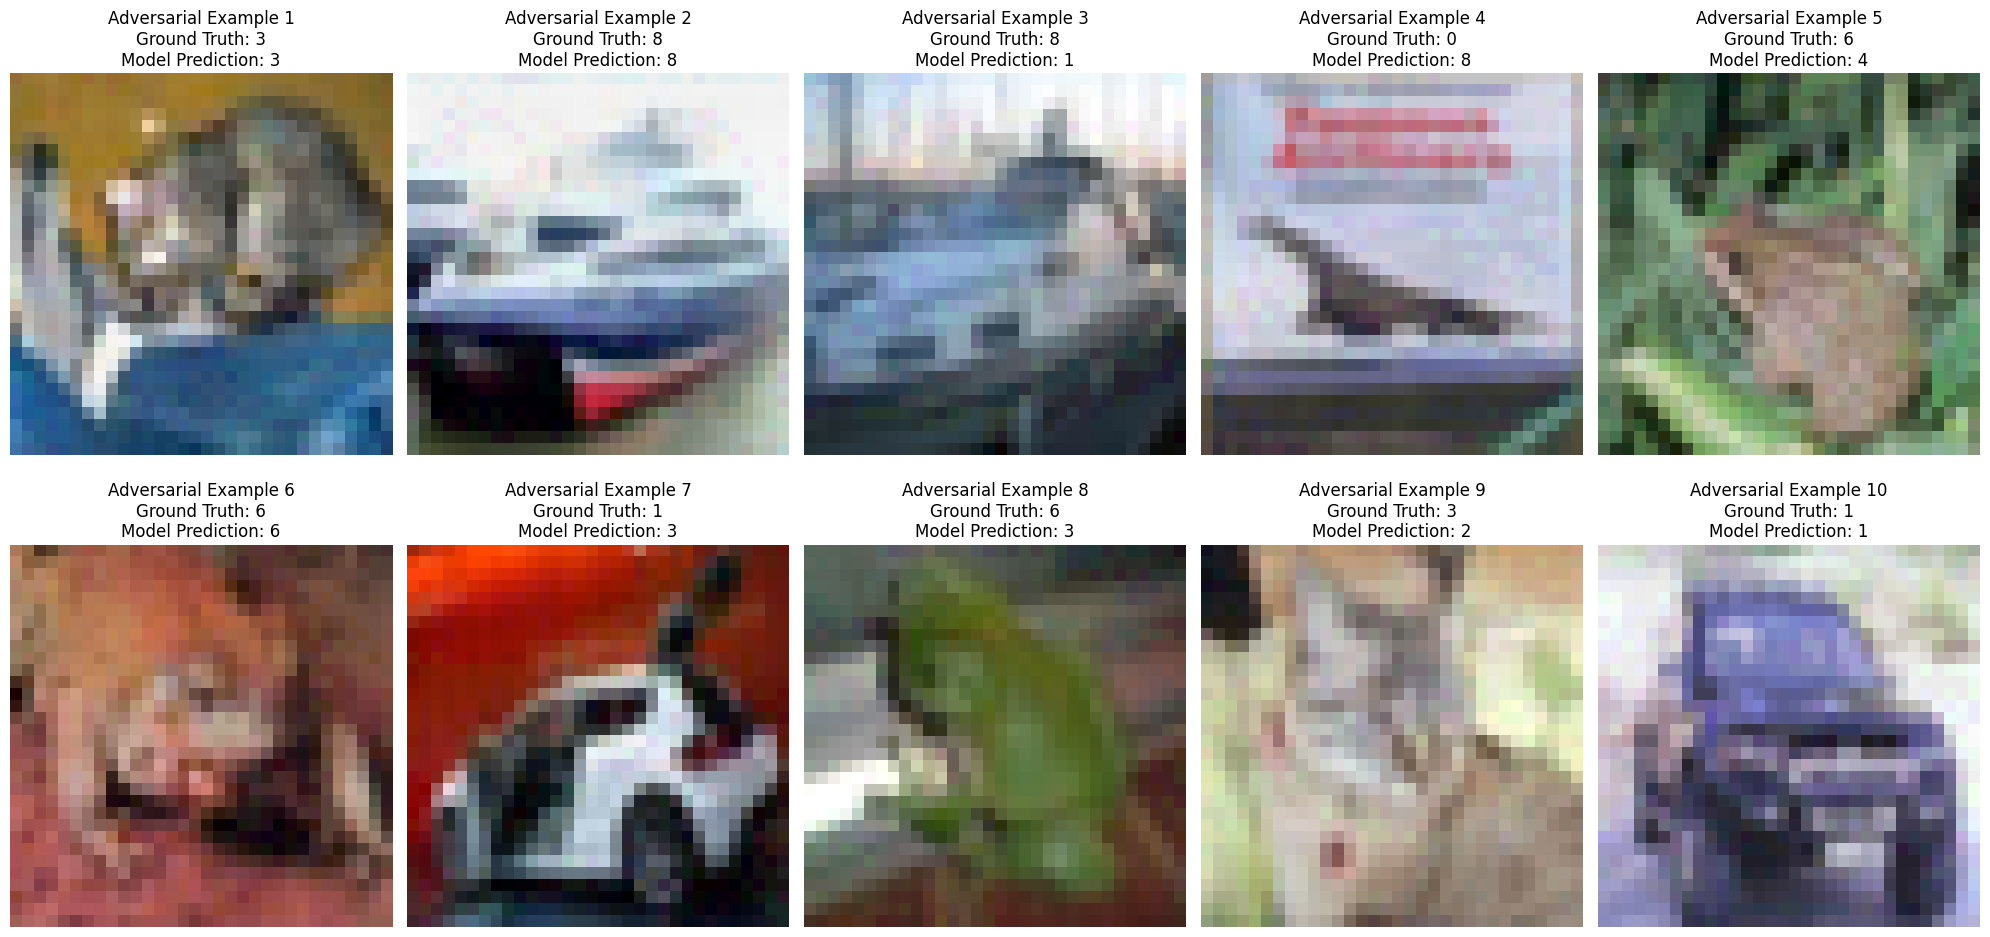

In [19]:
# *********** Your code starts here ***********
from matplotlib import pyplot as plt
model = ResNet18()
model = model.to(device)
model.load_state_dict(torch.load('model2.pt'))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
adversarial_examples = []
ground_truth_labels = []
model_predictions = []
count = 0
for (inputs, targets) in val_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  adv_x = pgd_attack(inputs, targets) #attack on image
  outputs = model(adv_x)  # output
  _, predicted = outputs.max(1) #predict
  adversarial_examples.extend(adv_x.cpu().detach().numpy()[:10].transpose(0, 2, 3, 1)) #re order the channels
  ground_truth_labels.extend(targets.cpu().detach().numpy()[:10])
  model_predictions.extend(predicted.cpu().detach().numpy()[:10])
  break

plt.figure(figsize=(20, 10))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(adversarial_examples[i])
  plt.title(f"Adversarial Example {i+1}\nGround Truth: {ground_truth_labels[i]}\nModel Prediction: {model_predictions[i]}")
  plt.axis('off')

plt.tight_layout()
plt.show()
# *********** Your code ends here *************

### Q5 (10 points)
Which adversarial training algorithm achieves the best robust accuracy in only 25 training epochs? Why do you think that adversarial training algorithm outperforms others? Do you encounter any difficulties when you implement this assignment?

The adversarial training algorithm that achieved the best robust accuracy in only 25 training epochs was adv_train, by ~5% over the second place. This is because I would imagine the simplicity of this approach allows the model to converge faster, whereas the other robust models would likely perform better over a longer time frame. There were less considerations in this approach (no mixup or anything of that nature), as it simply trained on the attacks themselves, which may have helped when only testing attacks and not attacks mixed with true images. And though it did better on robustness, it did worse on pure accuracy, highlighting a tradeoff.
I did not really encounter any difficulties. The only things I needed to do were in the attack set the gradients to be required, and increase the plot size for rendering.

## Submission Instructions

Please submit this  to Canvas, as well as results, as per instructions.
Please compress `First_Middle_Last_HW1/` into one zip file with the name `First_Middle_Last_HW1.zip` before uploading it to Canvas. The directory contains your notebook and four model checkpoints. As listed below:

- `Assignment_2.ipynb`: your code
- `model1.pt`: your model checkpoint with *natural training*
- `model2.pt`: your model checkpoint with *adv_train* training
- `model3.pt`: your model checkpoint with *adv_train_trades* training
- `model4.pt`: your model checkpoint with *adv_train_mixup* training

## Academic Integrity

This homework assignment must be done individually. Sharing code or model specifications is strictly prohibited. Homework discussions are allowed only on Piazza, according to the policy outlined on the course web page: [https://canvas.dartmouth.edu/courses/71530](https://canvas.dartmouth.edu/courses/71530). You are not allowed to search online for auxiliary software, reference models, architecture specifications, or additional data to solve the homework assignment. Your submission must be entirely your own work. That is, the code and the answers that you submit must be created, typed, and documented by you alone, based exclusively on the materials discussed in class, and released with the homework assignment. You can obviously consult the class slides posted in Canvas, your lecture notes, and the textbook. Important: the models you will submit for this homework assignment must be
trained exclusively on the specified data provided with this assignment. You can, of course, play with other datasets in your spare time. These rules will be strictly enforced, and any violation will be treated seriously.